In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import random
import requests
from PIL import Image
import io
import nltk

In [3]:
def read_dataset(filename="updated_dataset.json"):
    with open(filename, "r") as f:
        return json.load(f)

In [5]:
dataset = read_dataset()

In [7]:
import datetime
# Load the data into a DataFrame
data = pd.DataFrame.from_dict(dataset, orient='index')

data['post_count'] = data['posts'].apply(lambda x: len(x))
data['post_dates'] = data['posts'].apply(lambda x: [datetime.datetime.strptime(
    post['timestamp'], "%Y-%m-%dT%H:%M:%S%z").date() for post in x.values()])
data.drop(columns=['posts'], inplace=True)

# drop profile picture
data = data.drop(columns=['profile_picture_url'])

print(", ".join(data.columns))


name, biography, followers_count, follows_count, media_count, id, business_category_name, interests, post_count, post_dates


In [8]:
def post_date(data):
    dates_list = []
    years = {}
    for dates in data:
        for date in dates:
            dates_list.append(date)
            if date.year in years:
                years[date.year] += 1
            else:
                years[date.year] = 1
    total_days = sum(dt.toordinal() for dt in dates_list)
    average_date = datetime.date.fromordinal((total_days // len(dates_list)))
    return min(dates_list), max(dates_list), years ,average_date 


oldest, newest, posts_per_year,avg_date = post_date(data['post_dates'])
# Some stats
stats = pd.DataFrame({
    'Total number of users': [len(data)],
    'Number of users with posts': [len(data[data['post_count'] > 0])],
    'Number of users with no posts': [len(data[data['post_count'] == 0])],
    'Max number of posts': [data['post_count'].max().astype(int)],
    'Min number of posts': [data['post_count'].min().astype(int)],
    'Mean number of posts': [data['post_count'].mean().astype(int)],
    'Total number of posts': [data['post_count'].sum().astype(int)],
    'oldest post': [oldest],
    'newest post': [newest],
    'average post date': [avg_date],
}).transpose()
# remove header
stats.columns = ['']

# render
stats

,
Total number of users,264
Number of users with posts,264
Number of users with no posts,0
Max number of posts,500
Min number of posts,1
Mean number of posts,155
Total number of posts,41130
oldest post,2013-06-21
newest post,2023-03-24
average post date,2021-07-06


- The analysis shows that there are a total of 264 users in the dataset, all of whom have made posts. The maximum number of posts made by a user is 500, while the minimum is 1, and the average number of posts per user is 155. In total, there are 41,130 posts made by these users.

- The oldest post in the dataset dates back to June 21, 2013, while the newest post was made on March 24, 2023. On average, the posts in the dataset were made on July 6, 2021.

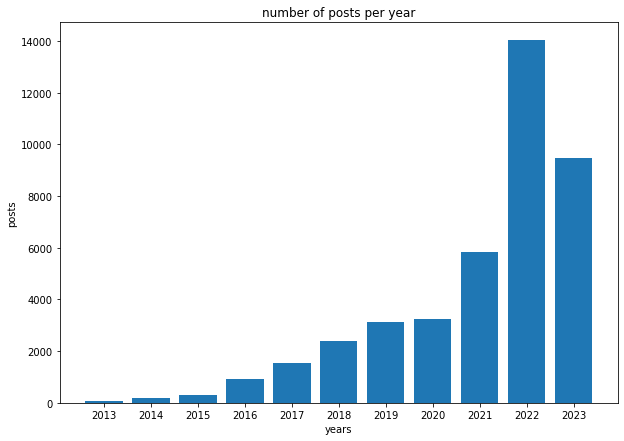

In [7]:
x_values = list(posts_per_year.keys())
y_values = list(posts_per_year.values())

fig = plt.figure(figsize=(10, 7))

# Create a bar plot
plt.bar(x_values, y_values)

plt.xticks(x_values, x_values)
# Add labels and title
plt.xlabel('years')
plt.ylabel('posts')
plt.title('number of posts per year')

# Show the plot
plt.show()


In [8]:
# Make a set for interests
interests = set()

for i in data['interests']:
    i = i.replace(", ", ",").split(",")
    for interest in i:
        interests.add(interest)
interests = list(interests)
interests.sort()

print("Number of interests: {}".format(len(interests)))

Number of interests: 26


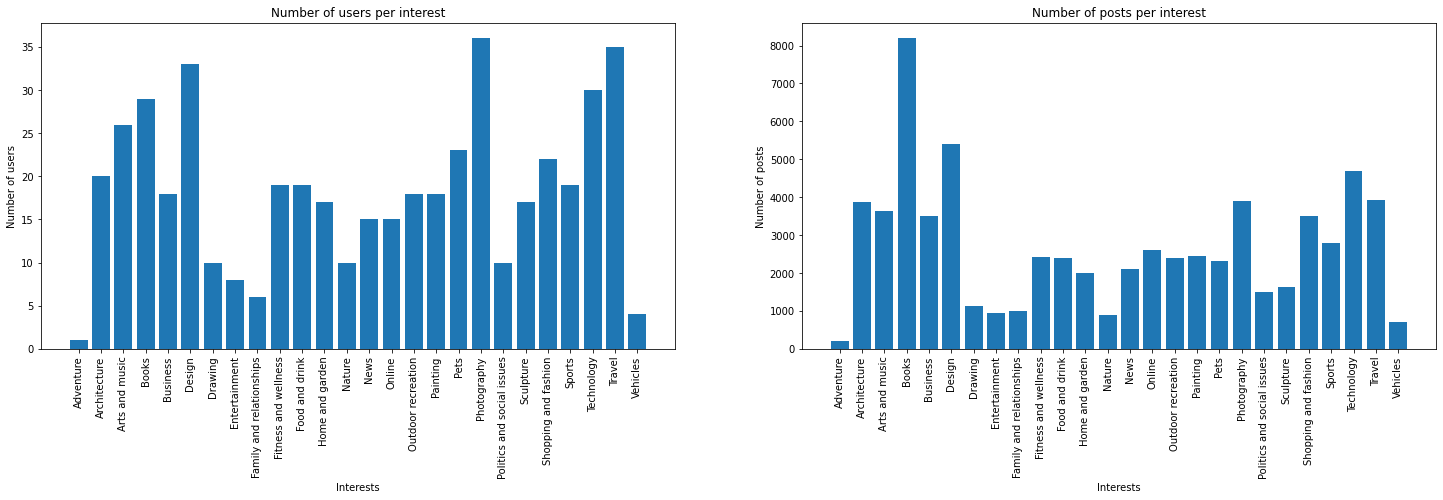

In [9]:
# Make a graph for the number of posts per interest
posts_count = []
for interest in interests:
    posts_count.append(data[data['interests'].str.contains(interest)]['post_count'].sum())

# Make a graph of the number of users per interest 
users_count = []
for interest in interests:
    users_count.append(len(data[data['interests'].str.contains(interest)]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 6))

# plot the graph with labels
ax1.bar(interests, users_count)
ax1.set_xticks(range(len(interests)))
ax1.set_xticklabels(interests, rotation=90)
ax1.set_xlabel("Interests")
ax1.set_ylabel("Number of users")
ax1.set_title("Number of users per interest")

# plot the graph with labels
ax2.bar(interests, posts_count)
ax2.set_xticks(range(len(interests)))
ax2.set_xticklabels(interests, rotation=90)
ax2.set_xlabel("Interests")
ax2.set_ylabel("Number of posts")
ax2.set_title("Number of posts per interest");

The interests of these users appear to be diverse and cover a wide range of topics. Some of the interests are related to physical activities such as fitness and wellness, outdoor recreation, and sports. Others are more artistic in nature, such as drawing, painting, sculpture, and photography. Some users are interested in intellectual pursuits like reading books, keeping up with news, and discussing politics and social issues. There are also practical interests such as home and garden, shopping and fashion, and business.Overall, the variety of interests among these users suggests that they have diverse and well-rounded lifestyles, with a mix of physical, intellectual, artistic, and practical pursuits.

In [12]:
def get_img(dataset, post_id, user, local=False, base="images", ext="jpg", video=False):
    img = None
    try:
        if dataset[user]["posts"][post_id].get('media_type', '') == "VIDEO" and not video:
            return None
        if not local:
            media_url = dataset[user]["posts"][post_id]['media_url']
            response = requests.get(media_url)
            img = response.content
            img = Image.open(io.BytesIO(img))
        if local:
            path = f"../../images/images/{user}/{post_id}.{ext}"
            img = Image.open(path)
    except Exception as e:
        print('Error: ', e)
    return img


AttributeError: 'function' object has no attribute 'set_subtitle'

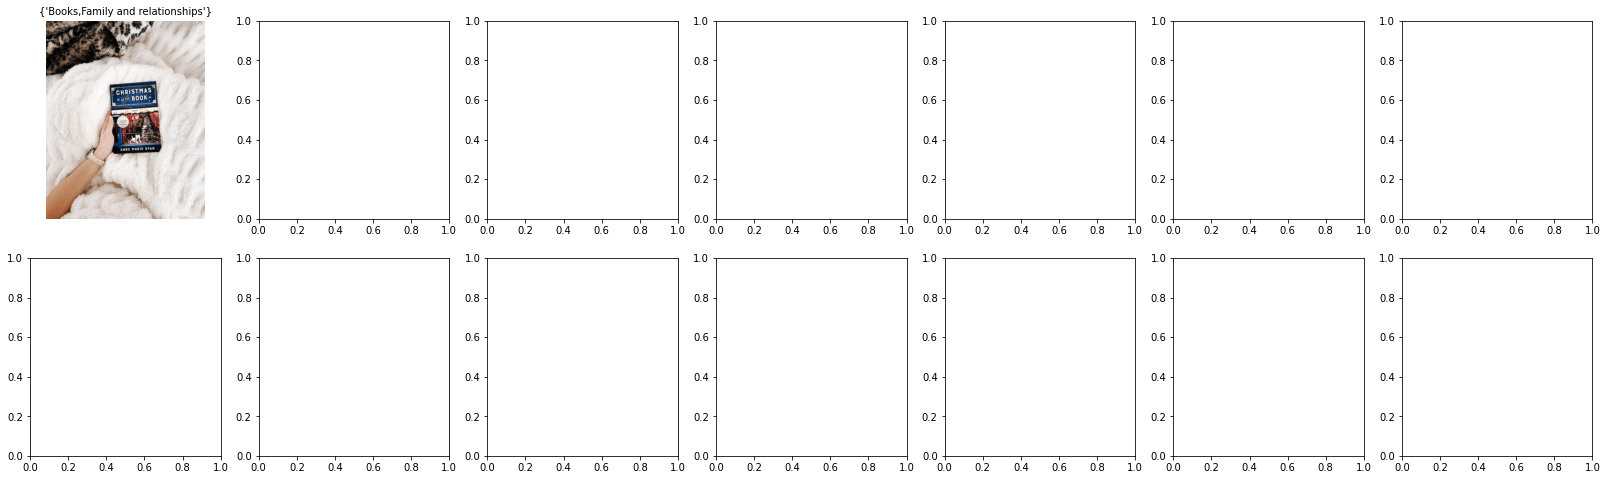

In [23]:
# Display some random posts photos in matplotlib
def display_random_posts(dataset, n=4, interest=None, user=None, local=False):
    if user is not None and user in dataset:
        dataset = {user: dataset[user]}
    elif interest is not None:
        dataset = {k: v for k, v in dataset.items() if interest.lower()
                   in v['interests'].lower()}

    _, ax = plt.subplots(2, n, figsize=(28, 8))
    i = 0
    while i < n * 2:
        user = random.choice(list(dataset.keys()))
        post = random.choice(list(dataset[user]['posts'].keys()))
        img = get_img(dataset, post, user, local=local)
        if img is None:
            continue

        ax[i // n, i % n].imshow(img)
        ax[i // n, i % n].axis('off')
        ax[i // n, i % n].set_title(dataset[user]['interests'], fontsize=10)
        ax[i // n, i % n].set.set_subtitle(user, fontsize=10)
        i += 1

    plt.show()


display_random_posts(dataset, n=7, local=True,interest="Family and Relationships")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aziz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aziz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


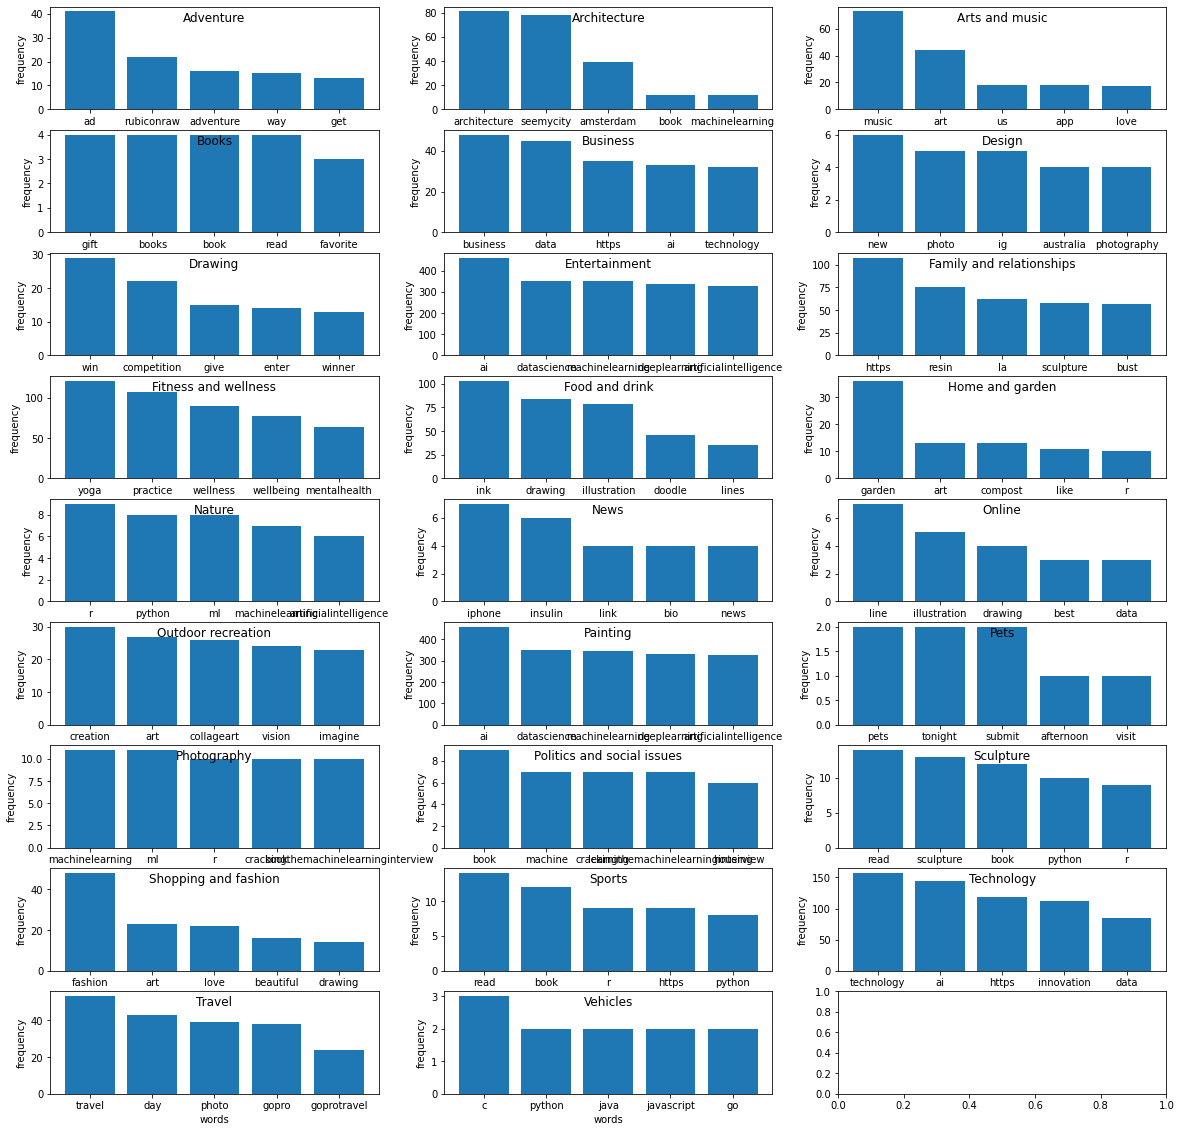

In [ ]:
from nltk.corpus import stopwords

# Load stop words
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define dictionary for each interest category
# Initialize dictionary for each interest category
interest_categories = {}
for interest in interests:
    interest_categories[interest] = {}

# Loop through each user
for username, user in dataset.items():
    # Loop through each post
    for post_id, post in user['posts'].items():
        # Loop through each hashtag in post
        for hashtag in post['hashtags']:
            # Loop through each interest category
            for interest_category, word_dict in interest_categories.items():
                # Check if hashtag is related to interest category
                if hashtag in interest_category:
                    # Tokenize caption and add words to corresponding dictionary
                    caption = post['caption']
                    tokens = nltk.word_tokenize(caption)
                    for token in tokens:
                        # Remove stop words and non-alphabetic words
                        if token.lower() not in stop_words and token.isalpha():
                            # Add word to dictionary or increment frequency
                            if token.lower() in word_dict:
                                word_dict[token.lower()] += 1
                            else:
                                word_dict[token.lower()] = 1

# Sort dictionaries by frequency in descending order
for interest_category, word_dict in interest_categories.items():
    interest_categories[interest_category] = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)

# Graph top 3 words for each interest category
num_interests = len(interest_categories)
top_words = 5
fig, ax = plt.subplots(num_interests // 3 + 1, 3, figsize=(20, 20))
for i, (interest_category, word_list) in enumerate(interest_categories.items()):
    x_values = [word for word, _ in word_list[:top_words]]
    y_values = [frequency for _, frequency in word_list[:top_words]]
    ax[i // 3, i % 3].bar(x_values, y_values)
    # make title inside graph
    ax[i // 3, i % 3].set_title(interest_category, y=0.8)
    ax[i // 3, i % 3].set_xlabel('words')
    ax[i // 3, i % 3].set_ylabel('frequency')

plt.show()